# Introduction to gradients and automatic differentiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2024-11-19 12:40:00.046963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Gradient tapes

In [5]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

In [6]:
# dy/dx = 2x = 2(3) = 6
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [17]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

In [18]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [19]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


In [20]:
my_vars = {
    'w': w,
    'b': b,
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-4.1637397, -1.2311405], dtype=float32)>

## Gradients with respect to a model

In [27]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    # Forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [28]:
for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')

kernel, shape: (3, 2)
bias, shape: (2,)


## Controlling what the tape watches

In [30]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [31]:
[var.name for var in tape.watched_variables()]

['x0:0']

In [32]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

# dy/dx = 2x = 2(3) = 6
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


In [34]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1) # Only track x1, not x0
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1) # softplus: f(x) = ln(1 + exp(x))
    y = y0 + y1
    ys = tf.reduce_sum(y)

# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## Intermediate results

In [35]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y

# Use the tape to compute the gradient of z w.r.t the intemediate value y
# dz/dy = 2y = 2x^2 = 2(9) = 18
print(tape.gradient(z, y).numpy())

18.0


In [36]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y

# dy/dx = 2x 
# dz/dx = dz/dy * dy/dx = 2y * 2x = 2(x^2) * 2x = 4x^3 
print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [38]:
del tape   # Drop the reference to the tape

## Gradients of non-scalar targets

In [40]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
    y0 = x**2
    y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


In [41]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y0 = x**2
    y1 = 1 / x
print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())
# Computes the sum of the gradients of each target

3.75


In [43]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
    y = x * [3., 4.]

print(tape.gradient(y, x).numpy())
# Computes the gradient of the sum

7.0


In [44]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

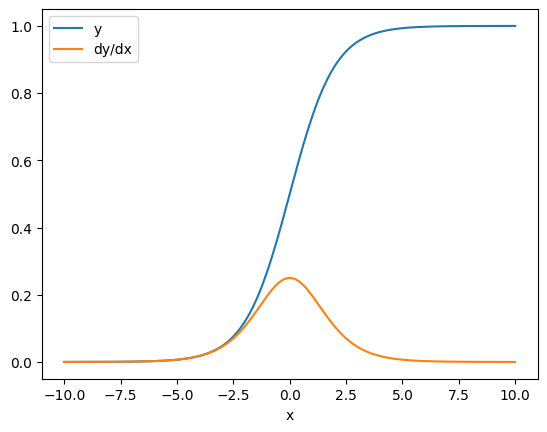

In [47]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Control flow

In [48]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1**2

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


In [49]:
dx = tape.gradient(result, x)

print(dx)

None


## Cases where `gradient` terns `None`

In [50]:
# When a target is not connected to a source
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


In [53]:
# When a variable is replaced with a tensor
x = tf.Variable(2.0)

for epoch in range(2):
    with tf.GradientTape() as tape:
        y = x+1 
    print(type(x).__name__, ":", tape.gradient(y, x))

    x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


In [58]:
# When calculations are done outside of TensorFlow

x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
    x2 = x**2

    # This step is calculated with NumPy
    y = np.mean(x2, axis=0)

    # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
    # using `tf.convert_to_tensor`.
    y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


In [60]:
# When taking gradients through an integer or string (they are not differentiable)

x = tf.constant(10) 

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


In [61]:
# When taking gradients through a stateful object

x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    # Update x1 = x1 + x0.
    x1.assign_add(x0)
    # The tape starts recording from x1.
    y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


## No gradient registered

In [62]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


## Zeros instead of None

In [64]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
